# Recursive multi-step forecasting

Recursive multi-step forecasting involves using the predicted values from previous time steps as input to forecast the values for the subsequent time steps. The model initially predicts one time step ahead and then uses that forecast as an input for the next time step, continuing this recursive process until the desired forecast horizon is reached.

To clarify, since the value of $t_{n-1}$ is required to predict $t_{n}$, and $t_{n-1}$ is unknown, a recursive process is applied in which, each new prediction is based on the previous one.

<p style="text-align: center">
<img src="../img/diagram-recursive-mutistep-forecasting.png" style="width: 650px">
<br>
<font size="2.5"> <i>Diagram of recursive multi-step forecasting.</i></font>
</p>

When using machine learning models for recursive multi-step forecasting, one of the major challenges is transforming the time series data into a matrix format that relates each value of the series to the preceding time window (lags). This process can be complex and time-consuming, requiring careful feature engineering to ensure the model can accurately capture the underlying patterns in the data.

<p style="text-align: center">
<img src="../img/matrix_transformation_with_exog_variable.png" style="width: 600px;">
<br>
<font size="2.5"> <i>Time series transformation including an exogenous variable.</i></font>
</p>

By using the classes `ForecasterRecursive`, it is possible to build machine learning models for recursive multi-step forecasting with ease. These classes can automatically transform the time series data into a matrix format suitable for input to a machine learning algorithm, and provide a range of options for tuning the model parameters to achieve the best possible performance.

## Libraries

In [1]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.recursive import ForecasterRecursive
from skforecast.datasets import fetch_dataset
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

## Data

h2o
---
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice(3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,https://github.com/robjhyndman
/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (204, 2)


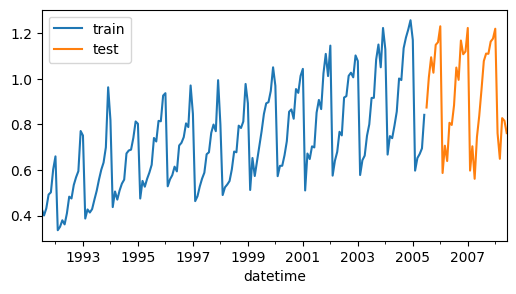

In [2]:
# Download data
# ==============================================================================
data = fetch_dataset(
    name="h2o", raw=True, kwargs_read_csv={"names": ["y", "datetime"], "header": 0}
)

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## Create and train forecaster

In [3]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 15
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-07-29 16:38:13 
Last fit date: 2024-07

## Prediction

In [4]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=36)
predictions.head(3)

2005-07-01    1.020833
2005-08-01    1.021721
2005-09-01    1.093488
Freq: MS, Name: pred, dtype: float64

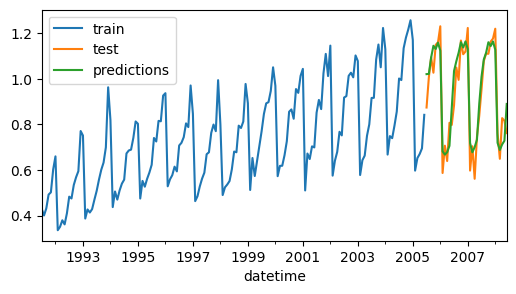

In [5]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [6]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.006023571131075229


## Prediction intervals

A prediction interval defines the interval within which the true value of `y` is expected to be found with a given probability. For example, the prediction interval (1, 99) can be expected to contain the true prediction value with 98% probability.

By default, every forecaster can estimate prediction intervals using the method `predict_interval`. For a detailed explanation of the different prediction intervals available in skforecast visit [Probabilistic forecasting](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/probabilistic-forecasting.html).

In [7]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(steps=36, interval=[5, 95], n_boot=100)
predictions.head(3)

,pred,lower_bound,upper_bound
2005-07-01,1.020833,0.975794,1.082322
2005-08-01,1.021721,0.976413,1.064850
2005-09-01,1.093488,1.010195,1.154976


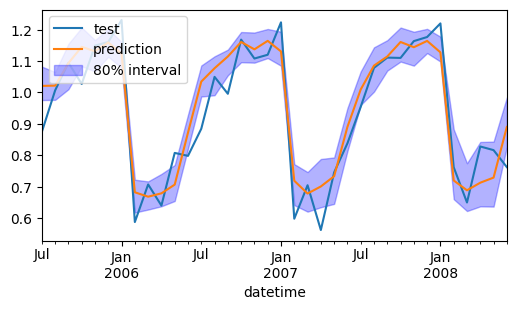

In [8]:
# Plot prediction interval
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_test.plot(ax=ax, label="test")
predictions['pred'].plot(ax=ax, label="prediction")
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'blue',
    alpha = 0.3,
    label = '80% interval'
)
ax.legend(loc="upper left");

## Feature importances

In [9]:
forecaster.get_feature_importances()

,feature,importance
11,lag_12,100
10,lag_11,43
0,lag_1,41
1,lag_2,41
5,lag_6,36
13,lag_14,33
2,lag_3,31
6,lag_7,30
14,lag_15,30
8,lag_9,26


## Extract training matrices

To examine how data is being transformed, it is possible to use the `create_train_X_y` method to generate the matrices that the forecaster is using to train the model. This approach enables gaining insight into the specific data manipulations that occur during the training process.

In [10]:
# Create training matrices
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(data_train)
X_train.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-10-01,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543,0.432159,0.400906,0.429795
1992-11-01,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543,0.432159,0.400906
1992-12-01,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543,0.432159
1993-01-01,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543
1993-02-01,0.751503,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369


In [11]:
y_train.head()

datetime
1992-10-01    0.568606
1992-11-01    0.595223
1992-12-01    0.771258
1993-01-01    0.751503
1993-02-01    0.387554
Freq: MS, Name: y, dtype: float64

## Prediction on training data

While the main focus of creating forecasting models is predicting future values, it's also useful to evaluate whether the model is learning from the training data. Predictions on the training data can help with this evaluation.

To obtain predictions on the training data, the `predict()` method of the regressor stored inside the forecaster object can be accessed, and the training matrix can be passed as an input to this method. By examining the predictions on the training data, analysts can get a better understanding of how the model is performing and make adjustments as necessary.

In [12]:
# Create training matrices
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(data_train)

In [13]:
# Predict using the internal regressor
# ==============================================================================
predictions_training = forecaster.regressor.predict(X_train)
predictions_training[:4]

array([0.55145568, 0.57320468, 0.73750462, 0.73500079])

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

If the Forecaster contains a transformation, it is necessary to apply the inverse transformation to the predictions. This is because the predictions are made on the transformed data, and the inverse transformation is required to obtain the original scale.

Check <a href="https://github.com/JoaquinAmatRodrigo/skforecast/issues/715">issue 715</a> for more information.

</div>

## Extract prediction matrices

Skforecast provides the `create_predict_X` method to generate the matrices that the forecaster is using to make predictions. This method can be used to gain insight into the specific data manipulations that occur during the prediction process.

In [14]:
# Create input matrix for predict method
# ==============================================================================
X_predict = forecaster.create_predict_X(steps=5)
X_predict

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
2005-07-01,0.842263,0.695248,0.670505,0.652590,0.597639,1.170690,1.257238,1.216037,1.181011,1.134432,0.994864,1.001593,0.856803,0.795129,0.739986
2005-08-01,1.020833,0.842263,0.695248,0.670505,0.652590,0.597639,1.170690,1.257238,1.216037,1.181011,1.134432,0.994864,1.001593,0.856803,0.795129
2005-09-01,1.021721,1.020833,0.842263,0.695248,0.670505,0.652590,0.597639,1.170690,1.257238,1.216037,1.181011,1.134432,0.994864,1.001593,0.856803
2005-10-01,1.093488,1.021721,1.020833,0.842263,0.695248,0.670505,0.652590,0.597639,1.170690,1.257238,1.216037,1.181011,1.134432,0.994864,1.001593
2005-11-01,1.145198,1.093488,1.021721,1.020833,0.842263,0.695248,0.670505,0.652590,0.597639,1.170690,1.257238,1.216037,1.181011,1.134432,0.994864


## Differentiation

Time series differentiation involves computing the differences between consecutive observations in the time series. When it comes to training forecasting models, differentiation offers the advantage of focusing on relative rates of change rather than directly attempting to model the absolute values. Once the predictions have been estimated, this transformation can be easily reversed to restore the values to their original scale.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about modeling time series differentiation, visit our example: <a href="https://www.cienciadedatos.net/documentos/py49-modelling-time-series-trend-with-tree-based-models.html">Modelling time series trend with tree based models</a>.

</div>

In [15]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 lags            = 15,
                 differentiation = 1
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Differentiation order: 1 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-07-29 16:38:18 
Last fit date: 2024-07-29

In [16]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=36)
predictions.head(3)

2005-07-01    0.909529
2005-08-01    0.941633
2005-09-01    1.007650
Freq: MS, Name: pred, dtype: float64